# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [ ]:
df = pd.read_csv("./data.csv")
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
df.shape

(5842, 2)

In [ ]:
# check class distribution
df['Sentiment'].value_counts(normalize = True)

neutral     0.535775
positive    0.317015
negative    0.147210
Name: Sentiment, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Sentence'], df['Sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Sentiment'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Tokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
print(f'Padding token: "{tokenizer.pad_token}", ID: {tokenizer.pad_token_id}')

Padding token: "[PAD]", ID: 0


# Tokenization

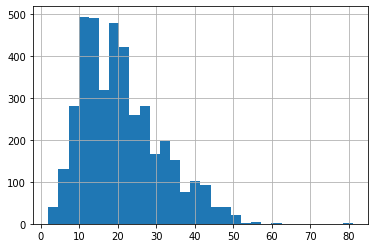

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 50

In [ ]:

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = tokens_train['input_ids']
attention_masks = tokens_train['attention_mask']

print('Original: ', tokens_train['input_ids'][0])
print('* Token IDs:', tokens_train['attention_mask'][0])
print('* Tokenized:', tokenizer.decode(tokens_train['input_ids'][0]))
print('* Attention_mask', tokens_train['attention_mask'][0])

Original:  [101, 10380, 4630, 3415, 9455, 3003, 2004, 5766, 3464, 24735, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* Token IDs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* Tokenized: [CLS] valeant names interim leader as ceo remains hospitalized [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
* Attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Convert Integer Sequences to Tensors

In [ ]:
train_labels[train_labels == 'neutral'] = 0
train_labels[train_labels == 'positive'] = 1
train_labels[train_labels == 'negative'] = 2

val_labels[val_labels == 'neutral'] = 0
val_labels[val_labels == 'positive'] = 1
val_labels[val_labels == 'negative'] = 2

test_labels[test_labels == 'neutral'] = 0
test_labels[test_labels == 'positive'] = 1
test_labels[test_labels == 'negative'] = 2

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
len(tokens_train['input_ids'][10])

50

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Find Class Weights and Set Loss 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.62209037 1.05169753 2.2641196 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# number of training epochs
epochs = 10

# Define Model Architecture

BERT Documentation: https://huggingface.co/docs/transformers/model_doc/bert

We are going to be using the `from_pretrained` module for this task. `BERTConfig` module is used to set the number of labels in the built-in classification head to be 3.

We can find the model documentation here: https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification

If you want to use the `from_pretrained` module: https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

In [ ]:
from transformers import BertForSequenceClassification, BertConfig

# Initializing a BERT configuration
configuration = BertConfig(num_labels=3)

# Initializing a model from the configuration
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=configuration)
bert_model.config.num_labels = 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
class BertForSentimentClassification(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        
        self.bert = bert_model

    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        
        return logits

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BertForSentimentClassification(bert_model)

# push the model to GPU
model = model.to(device)

In [ ]:
# Model parameters visualization
params = list(model.named_parameters())

print('BERT has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 1st Transformer Layer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 2nd Transformer Layer ====\n')

for p in params[21:37]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 3rd Transformer Layer ====\n')

for p in params[37:53]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-3:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

BERT has 201 different named parameters.

==== Embedding Layer ====

bert.bert.embeddings.word_embeddings.weight             (30522, 768)
bert.bert.embeddings.position_embeddings.weight           (512, 768)
bert.bert.embeddings.token_type_embeddings.weight           (2, 768)
bert.bert.embeddings.LayerNorm.weight                         (768,)
bert.bert.embeddings.LayerNorm.bias                           (768,)

==== 1st Transformer Layer ====

bert.bert.encoder.layer.0.attention.self.query.weight     (768, 768)
bert.bert.encoder.layer.0.attention.self.query.bias           (768,)
bert.bert.encoder.layer.0.attention.self.key.weight       (768, 768)
bert.bert.encoder.layer.0.attention.self.key.bias             (768,)
bert.bert.encoder.layer.0.attention.self.value.weight     (768, 768)
bert.bert.encoder.layer.0.attention.self.value.bias           (768,)
bert.bert.encoder.layer.0.attention.output.dense.weight   (768, 768)
bert.bert.encoder.layer.0.attention.output.dense.bias         (768,)


# Fine-Tune BERT

In [ ]:
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

# optimizer from hugging face transformers
from transformers import AdamW

In [ ]:
loss_func = torch.nn.CrossEntropyLoss(weight=weights)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases or LayerNorm weights
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

In [ ]:
def train_model(model, loss_func, epochs, train_dataloader, validation_dataloader):
    # Use GPU, if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Set learning rate and weight decay:
    lr = 0.001
    weight_decay = 0.01

    # Setup optimizer and LR scheduler 
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr=lr, weight_decay=weight_decay
    )

    loss_values = []
    train_acc_values = []

    eval_loss_vals = []
    eval_accs = []

    for epoch in range(0, epochs):
        t0 = time.time()

        total_loss = 0
        total_train_accuracy = 0

        model.train()

        with tqdm(train_dataloader, unit="batch") as train_pbar:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask, 
                )

                # Move the training logits and training labels to CPU
                train_logits = outputs.detach().cpu().numpy()
                label_ids_train = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of training sentences.
                tmp_train_accuracy = flat_accuracy(train_logits, label_ids_train)

                # Accumulate total training accuracy.
                total_train_accuracy += tmp_train_accuracy

                loss = loss_func(outputs, b_labels)

                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()

                # Update the learning rate.
                scheduler.step()

        # Calculate the average loss and accuracy over the training data.
        avg_train_loss = total_loss / len(train_dataloader)    
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)            
        
        # Store the loss and accuracy values for plotting the learning curve.
        loss_values.append(avg_train_loss)
        train_acc_values.append(avg_train_accuracy)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Average training accuracy: {0:.2f}".format(avg_train_accuracy))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                logits = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask
                )
            
            v_loss = loss_func(logits, b_labels)
            eval_loss += v_loss.item()
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            
            eval_accuracy += tmp_eval_accuracy
            
            nb_eval_steps += 1

        avg_eval_loss = eval_loss/nb_eval_steps
        avg_eval_acc = eval_accuracy/nb_eval_steps

        print("  * Loss: {0:.2f}".format(avg_eval_loss))
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))
        
        eval_loss_vals.append(avg_eval_loss)
        eval_accs.append(avg_eval_acc)
    print("Training complete!")
    return loss_values, train_acc_values, eval_loss_vals, eval_accs

In [ ]:
bert_train_loss_vals, bert_train_accs, bert_eval_loss_vals, bert_eval_accs = train_model(
    model=model,
    loss_func=loss_func,
    epochs=40, 
    train_dataloader=train_dataloader,
    validation_dataloader=val_dataloader
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Training (epoch 1): 100%|██████████| 64/64 [00:32<00:00,  1.99batch/s]


  * Average training loss: 0.85
  * Average training accuracy: 0.59
  * Training epoch took: 0:00:32
Running Validation...
  * Loss: 0.66
  * Accuracy: 0.69
  * Validation took: 0:00:02


Training (epoch 2): 100%|██████████| 64/64 [00:32<00:00,  1.96batch/s]


  * Average training loss: 0.63
  * Average training accuracy: 0.74
  * Training epoch took: 0:00:33
Running Validation...
  * Loss: 0.81
  * Accuracy: 0.62
  * Validation took: 0:00:02


Training (epoch 3): 100%|██████████| 64/64 [00:33<00:00,  1.92batch/s]


  * Average training loss: 0.73
  * Average training accuracy: 0.71
  * Training epoch took: 0:00:33
Running Validation...
  * Loss: 0.93
  * Accuracy: 0.60
  * Validation took: 0:00:03


Training (epoch 4): 100%|██████████| 64/64 [00:33<00:00,  1.90batch/s]


  * Average training loss: 1.05
  * Average training accuracy: 0.51
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.07
  * Accuracy: 0.59
  * Validation took: 0:00:02


Training (epoch 5): 100%|██████████| 64/64 [00:33<00:00,  1.90batch/s]


  * Average training loss: 1.13
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.14
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 6): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.14
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 7): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.14
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.16
  * Accuracy: 0.15
  * Validation took: 0:00:03


Training (epoch 8): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.16
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 9): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.14
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 10): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.31
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 11): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 12): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.13
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.12
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 13): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.12
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 14): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.31
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.29
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 15): 100%|██████████| 64/64 [00:34<00:00,  1.86batch/s]


  * Average training loss: 1.14
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 16): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.12
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 17): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.13
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.12
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 18): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 19): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.13
  * Average training accuracy: 0.34
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 20): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 21): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.13
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 22): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.36
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 23): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 24): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.36
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 25): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.31
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 26): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 27): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.30
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 28): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 29): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.31
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 30): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.12
  * Average training accuracy: 0.37
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 31): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 32): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.32
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 33): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.10
  * Average training accuracy: 0.34
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.11
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 34): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 35): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.33
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 36): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.31
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 37): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.35
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.15
  * Validation took: 0:00:02


Training (epoch 38): 100%|██████████| 64/64 [00:34<00:00,  1.88batch/s]


  * Average training loss: 1.11
  * Average training accuracy: 0.30
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.54
  * Validation took: 0:00:02


Training (epoch 39): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.10
  * Average training accuracy: 0.36
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.32
  * Validation took: 0:00:02


Training (epoch 40): 100%|██████████| 64/64 [00:34<00:00,  1.87batch/s]


  * Average training loss: 1.10
  * Average training accuracy: 0.34
  * Training epoch took: 0:00:34
Running Validation...
  * Loss: 1.10
  * Accuracy: 0.54
  * Validation took: 0:00:02
Training complete!


## Training and Validation Loss Graphs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss(train_loss_vals, eval_loss_vals):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    plt.title('BERT Baseline Loss') 
    ax1.plot(train_loss_vals, 'b-o', label = 'training loss')
    ax1.plot(eval_loss_vals, 'g-o', label = 'validation loss')
    ax1.set_xlabel("Epochs", color='k')
    ax1.set_ylabel("Loss", color='k')
    ax1.tick_params(axis='y', rotation=0, labelcolor='k' )
    plt.legend()
    plt.show()

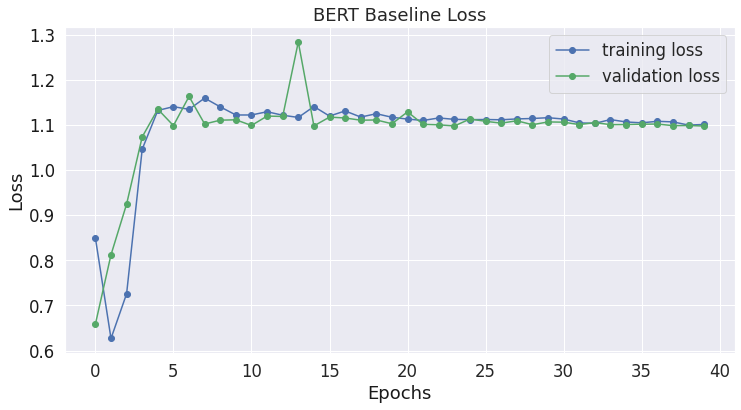

In [ ]:
plot_loss(bert_train_loss_vals, bert_eval_loss_vals)

## Training and Validation Accuracy Graphs

In [ ]:
def plot_acc(train_accs, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    plt.title('BERT Baseline Accuracy')
    ax1.plot(train_accs, 'b-o', label = 'training accuracy')
    ax1.plot(eval_accs, 'g-o', label = 'validation accuracy')
    ax1.set_ylabel("Accuracy", color='k')
    ax1.set_xlabel("Loss", color='k')
    ax1.tick_params(axis='y', rotation=0, labelcolor='k' )
    plt.legend()
    plt.show()

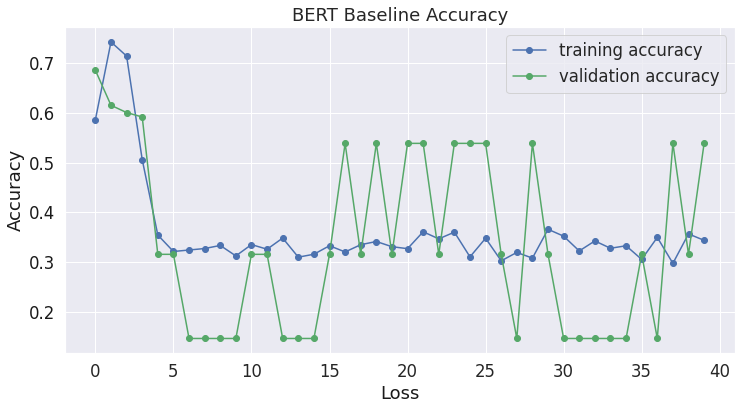

In [ ]:
plot_acc(bert_train_accs, bert_eval_accs)

## Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(input_ids=test_seq.to(device), attention_mask=test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
def test_flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1)
    labels_flat = np.array(labels.flatten())
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
test_flat_accuracy(preds, test_y)

0.5359179019384265

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       470
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       129

    accuracy                           0.54       877
   macro avg       0.18      0.33      0.23       877
weighted avg       0.29      0.54      0.37       877



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0
row_0,
0,470
1,278
2,129
